In [1]:
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
import joblib
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append("../scripts/")

In [3]:
from feature_creation import * 
from training import create_groupkfolds
import config

In [4]:
df = pd.read_csv(config.TRAINING_DATA_PATH)

In [5]:
model = 'adhoc'
fold =0
feature_pipeline = Pipeline(steps=[
                ("Language Features",LanguageFeature()),
                ("Graph Features",GraphFeatures()),
                ("Node Features",NodeFeatures()),
                ("Dataset Creation",FormatDataFrame()),
                ("Language One Hot Encoding",LanguageOHE(enc_lan=f"{model}/lan_encoder_{model}_{fold}.pkl",\
                                                         enc_lan_family=f"{model}/lan_family_encoder_{model}_{fold}.pkl"))])
train_data = feature_pipeline.fit_transform(df) 

Langauge Feature Started
Langauge Feature Ended
Graph Features Creation Started
Graph Feature Creation Ended
Node Features Creation Started
Node Features Creation Ended
DataFrame Creation Started
DataFrame Creation Ended!!
One Hot Encoding Started
One Hot Encoding created and Saved


In [7]:
train_data.to_csv(f"../data/train_data_new.csv",index=False)

In [12]:
train_data = pd.read_csv(f"../data/train_data_new.csv")

In [9]:
pip install boruta


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Iteration: 	1 / 1000
Confirmed: 	0
Tentative: 	618
Rejected: 	0
Iteration: 	2 / 1000
Confirmed: 	0
Tentative: 	618
Rejected: 	0
Iteration: 	3 / 1000
Confirmed: 	0
Tentative: 	618
Rejected: 	0
Iteration: 	4 / 1000
Confirmed: 	0
Tentative: 	618
Rejected: 	0
Iteration: 	5 / 1000
Confirmed: 	0
Tentative: 	618
Rejected: 	0
Iteration: 	6 / 1000
Confirmed: 	0
Tentative: 	618
Rejected: 	0
Iteration: 	7 / 1000
Confirmed: 	0
Tentative: 	618
Rejected: 	0
Iteration: 	8 / 1000
Confirmed: 	0
Tentative: 	80
Rejected: 	538
Iteration: 	9 / 1000
Confirmed: 	26
Tentative: 	54
Rejected: 	538
Iteration: 	10 / 1000
Confirmed: 	26
Tentative: 	54
Rejected: 	538
Iteration: 	11 / 1000
Confirmed: 	26
Tentative: 	54
Rejected: 	538
Iteration: 	12 / 1000
Confirmed: 	26
Tentative: 	35
Rejected: 	557
Iteration: 	13 / 1000
Confirmed: 	26
Tentative: 	35
Rejected: 	557
Iteration: 	14 / 1000
Confirmed: 	26
Tentative: 	35
Rejected: 	557
Iteration: 	15 / 1000
Confirmed: 	26
Tentative: 	35
Rejected: 	557
Iteration: 	16 / 10

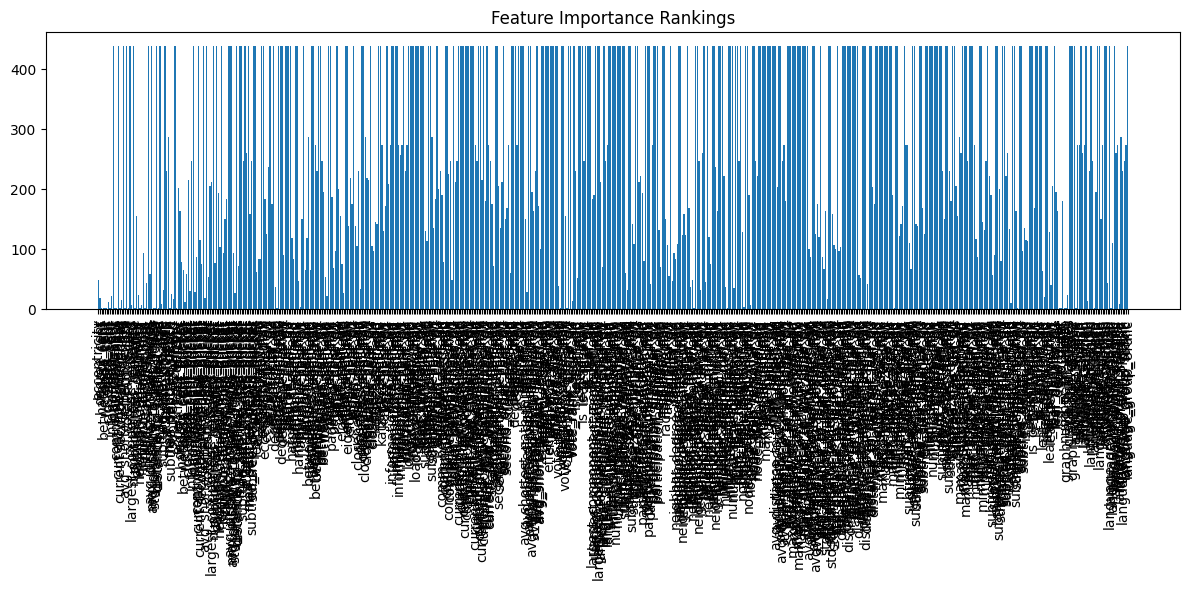

In [24]:
from boruta import BorutaPy
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

# Prepare data
X = train_data.drop(columns=config.TRAIN_DROP_COLS)
y = train_data['is_root']

# Initialize LGBM with more specific parameters
lgbm = LGBMClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    verbose=-1,
    max_depth=5,  # Add max_depth to control tree complexity
    learning_rate=0.1  # Add learning rate
)

# Initialize Boruta with modified parameters
boruta_selector = BorutaPy(
    estimator=lgbm,
    n_estimators=100,  # Set a specific number instead of 'auto'
    max_iter=1000,  # Limit the number of iterations
    verbose=2,
    random_state=42,
    perc=90  # Percentage of features to keep in each iteration
)

# Fit Boruta
boruta_selector.fit(X, y)

# Get selected feature mask and names
selected_features = X.columns[boruta_selector.support_].tolist()
tentative_features = X.columns[boruta_selector.support_weak_].tolist()

print("\nSelected features:")
print(selected_features)
print("\nTentative features:")
print(tentative_features)

# Plot feature importance rankings
plt.figure(figsize=(12, 6))
plt.title('Feature Importance Rankings')
plt.bar(range(len(boruta_selector.ranking_)), boruta_selector.ranking_)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.tight_layout()
plt.show()

In [25]:
len(selected_features)

31

In [27]:
print(selected_features)

['harmoni_cent', 'betweeness_cent', 'page_cent', 'eigen_cent', 'katz_cent', 'subgraph_cent', 'comm_betweenness', 'current_flow_betweenness', 'avg_shortest_path_length', 'vote_rank_score', 'subtree_size_variance', 'neighbor_degree_mean', 'num_leaf_neighbors', 'avg_distance_to_leaf_nodes', 'std_distance_to_leaf_nodes', 'distance_to_nearest_leaf', 'min_subtree_depth', 'leaf_density', 'degree_cent_std', 'vote_rank_score_std', 'vote_rank_score_skew', 'neighbor_degree_max_std', 'num_leaf_neighbors_std', 'min_subtree_size_std', 'sov_order', 'svo_order', 'number_of_nodes', 'graph_avg_path_length', 'language_Chinese', 'language_Japanese', 'language_group_Germanic']


In [32]:
# Calculate correlation matrix for selected features
correlation_matrix = X.corr()

# Find highly correlated feature pairs (>0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):  # Start from i+1 to avoid duplicates
        if abs(correlation_matrix.iloc[i,j]) > 0.9:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i,j]
            high_corr_pairs.append((feat1, feat2, corr_value))

# Print results
print("Highly correlated feature pairs (correlation > 0.9):")
print("\nFeature 1 | Feature 2 | Correlation")
print("-" * 50)
for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1:30} | {feat2:30} | {corr:.3f}")


Highly correlated feature pairs (correlation > 0.9):

Feature 1 | Feature 2 | Correlation
--------------------------------------------------
eccentricity                   | max_height                     | 1.000
eccentricity                   | max_distance_to_any_node       | 1.000
eccentricity                   | distance_to_farthest_leaf      | 1.000
eccentricity                   | max_subtree_depth              | 1.000
degree_cent                    | page_cent                      | 0.991
degree_cent                    | katz_cent                      | 0.992
degree_cent                    | subgraph_cent                  | 0.994
degree_cent                    | degree                         | 1.000
degree_cent                    | effective_size                 | 1.000
degree_cent                    | num_subtrees_removed           | 1.000
degree_cent                    | num_subtrees                   | 1.000
harmoni_cent                   | betweeness_cent                | 0

In [46]:
# For each highly correlated pair, decide which feature to keep based on variance and mutual information
from sklearn.feature_selection import mutual_info_classif
import numpy as np

features_to_drop = set()

if high_corr_pairs:  # Only proceed if there are highly correlated pairs
    # Calculate variance for all features
    variances = X.var()
    
    # Calculate mutual information scores
    mi_scores = mutual_info_classif(X, y)
    mi_dict = dict(zip(X.columns, mi_scores))
    
    print("\nFeature Selection Analysis for Highly Correlated Pairs:")
    print("\nFeature 1 | Feature 2 | Decision Reason | Keep")
    print("-" * 80)
    
    for feat1, feat2, corr in high_corr_pairs:
        # Check if either feature is already marked for dropping
        if feat1 in features_to_drop:
            keep = feat2
            reason = f"{feat1} already marked for dropping"
        elif feat2 in features_to_drop:
            keep = feat1
            reason = f"{feat2} already marked for dropping"
        else:
            # Calculate scores only if neither feature is marked for dropping
            var1 = variances[feat1]
            var2 = variances[feat2]
            mi1 = mi_dict[feat1]
            mi2 = mi_dict[feat2]
            score1 = var1 * mi1
            score2 = var2 * mi2
            
            if score1 >= score2:
                features_to_drop.add(feat2)
                keep = feat1
                reason = "Higher variance-MI score"
            else:
                features_to_drop.add(feat1)
                keep = feat2
                reason = "Higher variance-MI score"
            
        print(f"{feat1:30} | {feat2:30} | {reason:20} | {keep}")

    print("\nFeatures to drop:", list(features_to_drop))
else:
    print("\nNo highly correlated features found. No features need to be dropped.")



Feature Selection Analysis for Highly Correlated Pairs:

Feature 1 | Feature 2 | Decision Reason | Keep
--------------------------------------------------------------------------------
eccentricity                   | max_height                     | Higher variance-MI score | eccentricity
eccentricity                   | max_distance_to_any_node       | Higher variance-MI score | max_distance_to_any_node
eccentricity                   | distance_to_farthest_leaf      | eccentricity already marked for dropping | distance_to_farthest_leaf
eccentricity                   | max_subtree_depth              | eccentricity already marked for dropping | max_subtree_depth
degree_cent                    | page_cent                      | Higher variance-MI score | degree_cent
degree_cent                    | katz_cent                      | Higher variance-MI score | degree_cent
degree_cent                    | subgraph_cent                  | Higher variance-MI score | degree_cent
degree_cent  

In [47]:
len(features_to_drop)

339

{'avg_distance_to_all_nodes',
 'avg_distance_to_all_nodes_bucket',
 'avg_distance_to_all_nodes_iqr',
 'avg_distance_to_all_nodes_mean',
 'avg_distance_to_all_nodes_median',
 'avg_distance_to_all_nodes_q1',
 'avg_distance_to_all_nodes_q2',
 'avg_distance_to_all_nodes_q3',
 'avg_distance_to_all_nodes_skew',
 'avg_distance_to_all_nodes_std',
 'avg_distance_to_leaf_nodes',
 'avg_distance_to_leaf_nodes_q2',
 'avg_shortest_path_length',
 'avg_shortest_path_length_bucket',
 'avg_shortest_path_length_iqr',
 'avg_shortest_path_length_q1',
 'avg_shortest_path_length_q2',
 'avg_shortest_path_length_q3',
 'avg_shortest_path_length_std',
 'betweeness_cent',
 'betweeness_cent_bucket',
 'betweeness_cent_iqr',
 'betweeness_cent_mean',
 'betweeness_cent_median',
 'betweeness_cent_q1',
 'betweeness_cent_q2',
 'betweeness_cent_q3',
 'betweeness_cent_skew',
 'closeness_cent',
 'closeness_cent_bucket',
 'closeness_cent_median',
 'closeness_cent_q2',
 'comm_betweenness',
 'comm_betweenness_bucket',
 'comm_b

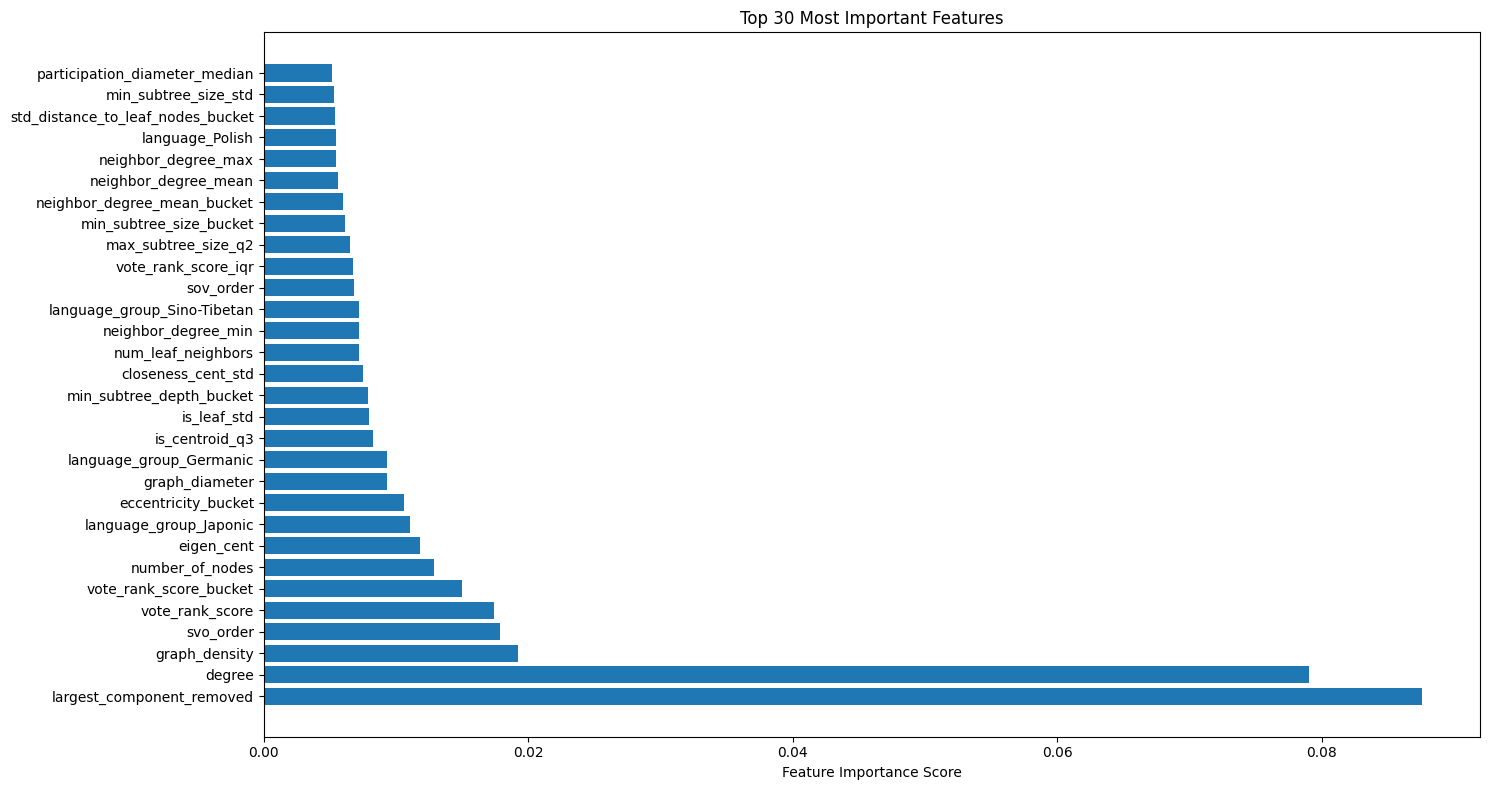


Feature Importance Scores (Top 30):
--------------------------------------------------
 1. largest_component_removed                0.0876
 2. degree                                   0.0791
 3. graph_density                            0.0192
 4. svo_order                                0.0179
 5. vote_rank_score                          0.0174
 6. vote_rank_score_bucket                   0.0150
 7. number_of_nodes                          0.0129
 8. eigen_cent                               0.0118
 9. language_group_Japonic                   0.0111
10. eccentricity_bucket                      0.0106
11. graph_diameter                           0.0093
12. language_group_Germanic                  0.0093
13. is_centroid_q3                           0.0082
14. is_leaf_std                              0.0080
15. min_subtree_depth_bucket                 0.0079
16. closeness_cent_std                       0.0075
17. num_leaf_neighbors                       0.0072
18. neighbor_degree_min     

In [55]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

# Load the XGBoost model
model_path = '../resources/xgb/xgb_1.pkl'
model = joblib.load(model_path)

# Get feature importance scores
importance_scores = model.feature_importances_

# Get feature names from model
feature_names = model.get_booster().feature_names

# Create list of tuples with feature names and importance scores
importance_tuples = list(zip(feature_names, importance_scores))
importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(15, 8))
features = [x[0] for x in importance_tuples[:30]]  # Top 30 features
scores = [x[1] for x in importance_tuples[:30]]

plt.barh(range(len(features)), scores)
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance Score')
plt.title('Top 30 Most Important Features')
plt.tight_layout()
plt.show()

# Print feature importance scores in descending order
print("\nFeature Importance Scores (Top 30):")
print("-" * 50)
for i, (feature, score) in enumerate(importance_tuples[:30], 1):
    print(f"{i:2d}. {feature:40} {score:,.4f}")


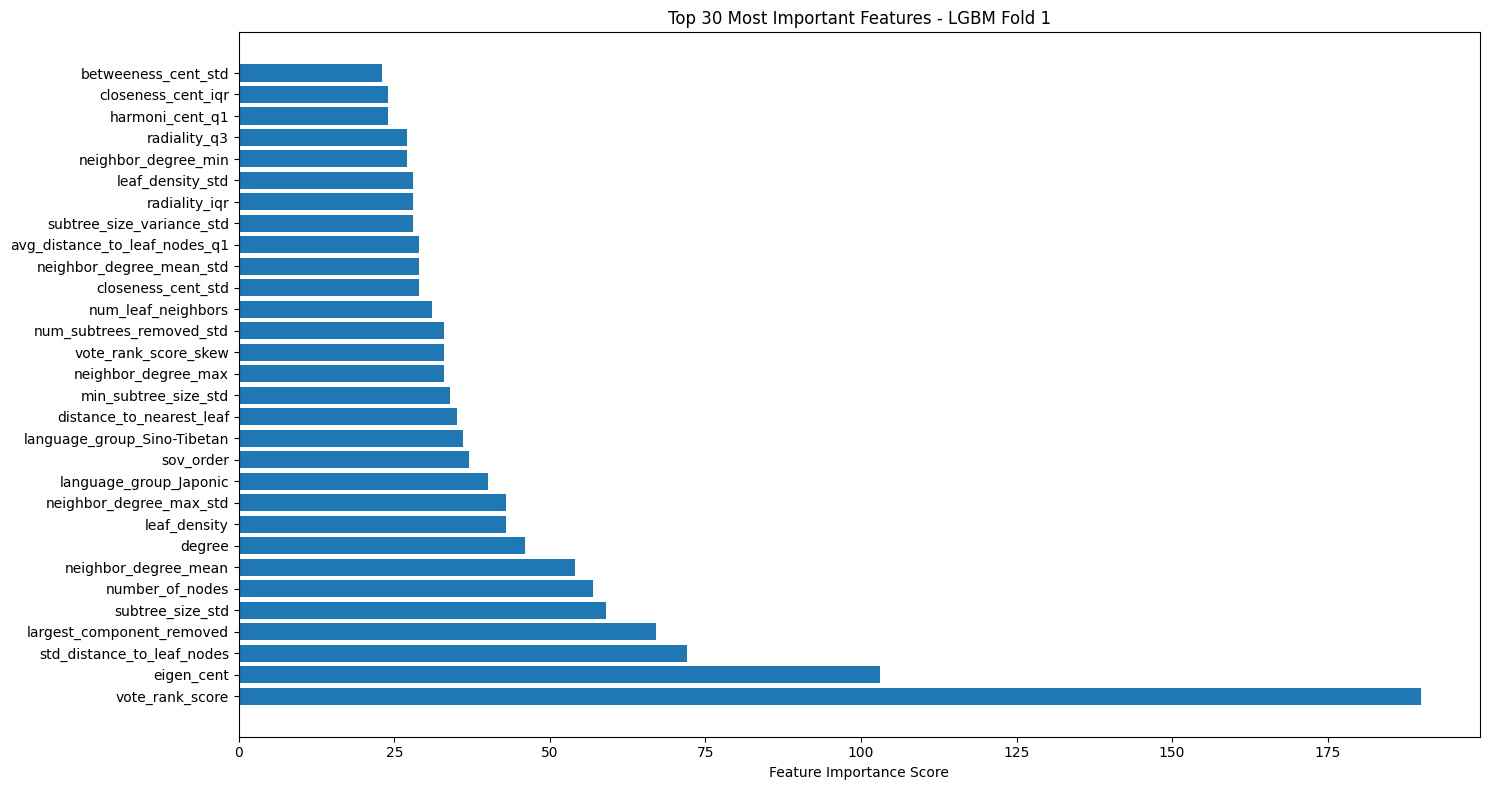


Feature Importance Scores (Top 30) - LGBM Fold 1:
--------------------------------------------------
 1. vote_rank_score                          190.0000
 2. eigen_cent                               103.0000
 3. std_distance_to_leaf_nodes               72.0000
 4. largest_component_removed                67.0000
 5. subtree_size_std                         59.0000
 6. number_of_nodes                          57.0000
 7. neighbor_degree_mean                     54.0000
 8. degree                                   46.0000
 9. leaf_density                             43.0000
10. neighbor_degree_max_std                  43.0000
11. language_group_Japonic                   40.0000
12. sov_order                                37.0000
13. language_group_Sino-Tibetan              36.0000
14. distance_to_nearest_leaf                 35.0000
15. min_subtree_size_std                     34.0000
16. neighbor_degree_max                      33.0000
17. vote_rank_score_skew                     33.

In [56]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

# Load the LGBM model for fold 1
model_path = '../resources/lgbm/lgbm_1.pkl'
model = joblib.load(model_path)

# Get feature importance scores
importance_scores = model.feature_importances_

# Get feature names from model
feature_names = model.feature_name_

# Create list of tuples with feature names and importance scores
importance_tuples = list(zip(feature_names, importance_scores))
importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(15, 8))
features = [x[0] for x in importance_tuples[:30]]  # Top 30 features
scores = [x[1] for x in importance_tuples[:30]]

plt.barh(range(len(features)), scores)
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance Score')
plt.title('Top 30 Most Important Features - LGBM Fold 1')
plt.tight_layout()
plt.show()

# Print feature importance scores in descending order
print("\nFeature Importance Scores (Top 30) - LGBM Fold 1:")
print("-" * 50)
for i, (feature, score) in enumerate(importance_tuples[:30], 1):
    print(f"{i:2d}. {feature:40} {score:,.4f}")



Features with Low Importance in Both Models (Bottom 25%):
----------------------------------------------------------------------
Total redundant features: 93

 1. avg_distance_to_all_nodes_max           
    LGBM Score: 0.000000
    XGB Score:  0.000000

 2. avg_distance_to_all_nodes_min           
    LGBM Score: 0.000000
    XGB Score:  0.000000

 3. avg_distance_to_leaf_nodes_max          
    LGBM Score: 0.000000
    XGB Score:  0.000000

 4. avg_distance_to_leaf_nodes_min          
    LGBM Score: 0.000000
    XGB Score:  0.000000

 5. avg_shortest_path_length_max            
    LGBM Score: 0.000000
    XGB Score:  0.000000

 6. avg_shortest_path_length_min            
    LGBM Score: 0.000000
    XGB Score:  0.000000

 7. betweeness_cent_max                     
    LGBM Score: 0.000000
    XGB Score:  0.000000

 8. betweeness_cent_min                     
    LGBM Score: 0.000000
    XGB Score:  0.000000

 9. closeness_cent_max                      
    LGBM Score: 0.000000
  

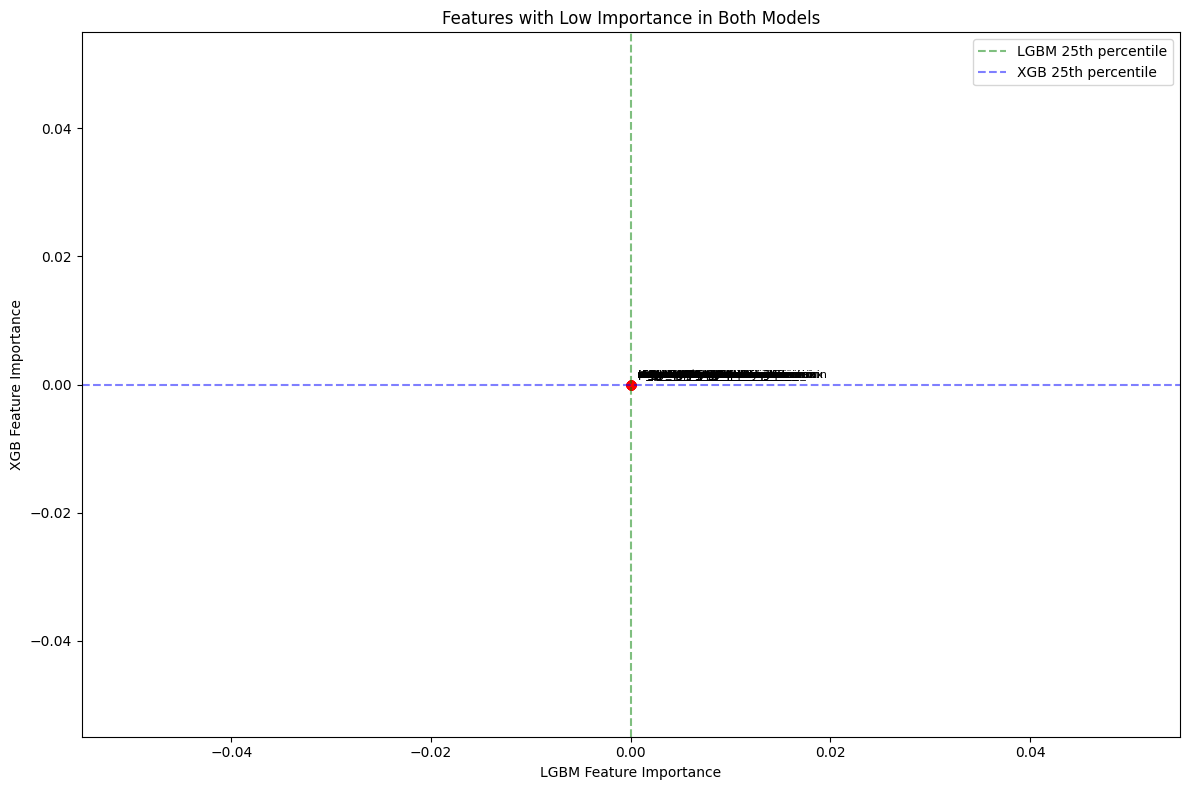


Redundant features list has been saved to '../resources/redundant_features.txt'


In [59]:
# Get feature importance scores from both models
xgb_model_path = '../resources/xgb/xgb_1.pkl'
xgb_model = joblib.load(xgb_model_path)

# Get XGB feature importance scores
xgb_importance_scores = xgb_model.feature_importances_
xgb_feature_names = xgb_model.get_booster().feature_names  # Get feature names from XGB booster

# Create list of tuples with feature names and importance scores for XGB
xgb_importance_tuples = list(zip(xgb_feature_names, xgb_importance_scores))
xgb_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Calculate importance thresholds (bottom 25% for each model)
lgbm_threshold = np.percentile([score for _, score in importance_tuples], 25)
xgb_threshold = np.percentile([score for _, score in xgb_importance_tuples], 25)

# Get truly redundant features - only those that are unimportant in BOTH models
redundant_features = set()
for feature in xgb_feature_names:
    lgbm_score = next(score for feat, score in importance_tuples if feat == feature)
    xgb_score = next(score for feat, score in xgb_importance_tuples if feat == feature)
    
    # Only consider feature redundant if it's in bottom 25% for both models
    if lgbm_score <= lgbm_threshold and xgb_score <= xgb_threshold:
        redundant_features.add(feature)

print("\nFeatures with Low Importance in Both Models (Bottom 25%):")
print("-" * 70)
print(f"Total redundant features: {len(redundant_features)}\n")

# Print details for redundant features
for i, feature in enumerate(sorted(redundant_features), 1):
    # Get scores from both models
    lgbm_score = next(score for feat, score in importance_tuples if feat == feature)
    xgb_score = next(score for feat, score in xgb_importance_tuples if feat == feature)
    
    print(f"{i:2d}. {feature:40}")
    print(f"    LGBM Score: {lgbm_score:,.6f}")
    print(f"    XGB Score:  {xgb_score:,.6f}")
    print()

# Create scatter plot comparing low importance features
plt.figure(figsize=(12, 8))

# Get scores for redundant features
redundant_lgbm_scores = [next(score for feat, score in importance_tuples if feat == feature) 
                        for feature in redundant_features]
redundant_xgb_scores = [next(score for feat, score in xgb_importance_tuples if feat == feature)
                       for feature in redundant_features]

plt.scatter(redundant_lgbm_scores, redundant_xgb_scores, alpha=0.6, c='red')

# Add feature labels
for i, feature in enumerate(redundant_features):
    plt.annotate(feature, (redundant_lgbm_scores[i], redundant_xgb_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.axvline(x=lgbm_threshold, color='g', linestyle='--', alpha=0.5, label='LGBM 25th percentile')
plt.axhline(y=xgb_threshold, color='b', linestyle='--', alpha=0.5, label='XGB 25th percentile')

plt.xlabel('LGBM Feature Importance')
plt.ylabel('XGB Feature Importance')
plt.title('Features with Low Importance in Both Models')
plt.legend()

plt.tight_layout()
plt.show()

# Save redundant features to a file
with open('../resources/redundant_features.txt', 'w') as f:
    for feature in sorted(redundant_features):
        f.write(f"'{feature}',\n")

print("\nRedundant features list has been saved to '../resources/redundant_features.txt'")